In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import joypy

from scipy.sparse import csr_matrix

In [4]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [5]:
sc.set_figure_params(dpi=100, facecolor=None, color_map="seismic", frameon=False, vector_friendly=True, transparent=True)
sc.settings._vector_friendly = False

In [6]:
# set working directory
project_dir = "/Users/cenkcelik/Cenk_scoring/"
working_dir = project_dir + ""
os.chdir(working_dir)

# set figure directory
figure_dir = working_dir + "figures/"

# processed data directory
processed_data = working_dir + "processed_data/"

In [7]:
# import a local package
import sys
sys.path.append("/Users/cenkcelik/Documents/GitHub/EnrichMap/")
import enrichmap as em

In [8]:
adata = sq.datasets.visium_hne_adata()

In [9]:
adata.layers["counts"] = adata.raw.X.copy()

In [10]:
adata.X = adata.layers["counts"].copy()

### Log1p

In [11]:
normalised = sc.pp.normalize_total(adata, target_sum=1e4, layer="counts", inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(normalised["X"], copy=True)

### Shifted logarithm

In [12]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, layer="counts", inplace=False)
adata.layers["shifted_log"] = sc.pp.log1p(scales_counts["X"], copy=True)

### Scran normalisation

In [13]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, layer="counts")
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

data_mat = adata_pp.X.T

ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

del adata_pp

ro.r("""
    library(scran)
    library(BiocParallel)
    sce <- SingleCellExperiment(list(counts=data_mat))
    size_factors = sizeFactors(computeSumFactors(sce, clusters = input_groups, min.mean = 0.1, BPPARAM = MulticoreParam()))
""")

size_factors = ro.r("size_factors")
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
scran = csr_matrix(scran)
adata.layers["scran_norm"] = sc.pp.log1p(scran, copy=True)

### Analytic pearson

In [14]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, layer="counts", inplace=False)
adata.layers["analytic_pearson"] = csr_matrix(analytic_pearson["X"])

### Square root

In [15]:
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, layer="counts", inplace=False)["X"])

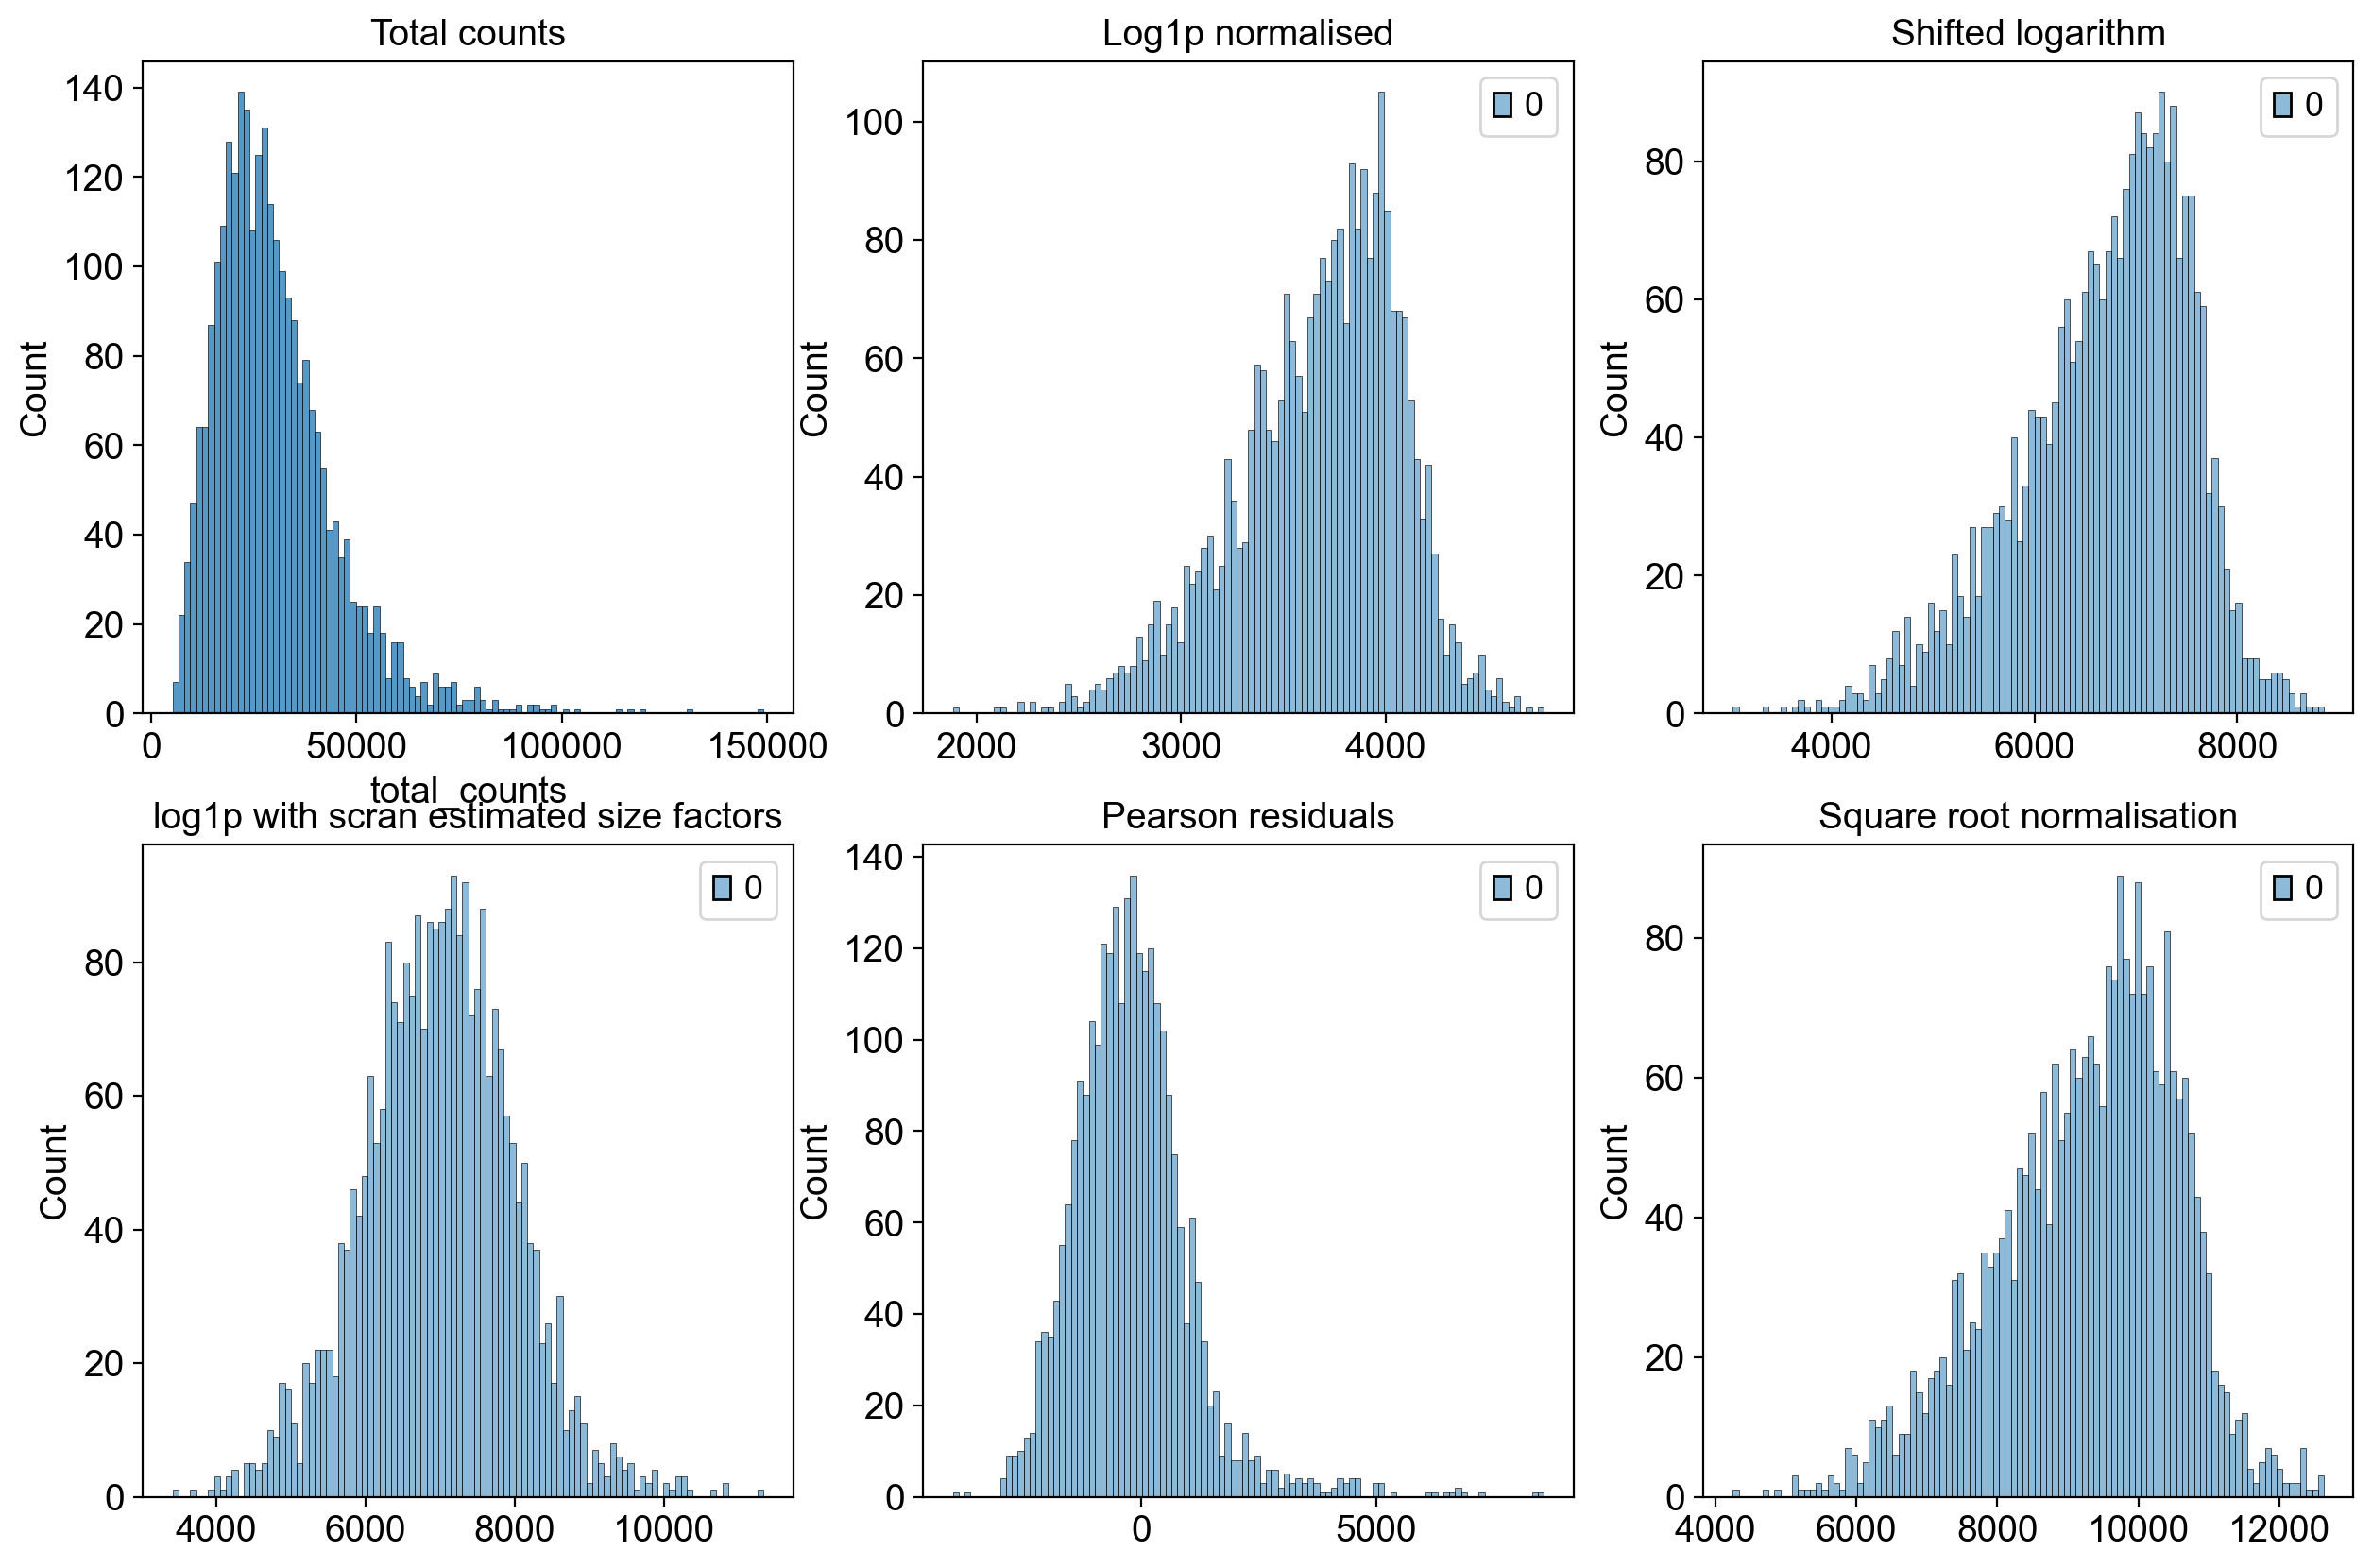

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0, 0])
axes[0, 0].set_title("Total counts")
axes[0, 0].grid(False)
sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[0, 1])
axes[0, 1].set_title("Log1p normalised")
axes[0, 1].grid(False)
sns.histplot(adata.layers["shifted_log"].sum(1), bins=100, kde=False, ax=axes[0, 2])
axes[0, 2].set_title("Shifted logarithm")
axes[0, 2].grid(False)
sns.histplot(adata.layers["scran_norm"].sum(1), bins=100, kde=False, ax=axes[1, 0])
axes[1, 0].set_title("log1p with scran estimated size factors")
axes[1, 0].grid(False)
sns.histplot(adata.layers["analytic_pearson"].sum(1), bins=100, kde=False, ax=axes[1, 1])
axes[1, 1].set_title("Pearson residuals")
axes[1, 1].grid(False)
sns.histplot(adata.layers["sqrt_norm"].sum(1), bins=100, kde=False, ax=axes[1, 2])
axes[1, 2].set_title("Square root normalisation")
axes[1, 2].grid(False)
plt.savefig(figure_dir + "normalisation_methods.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
sc.tl.rank_genes_groups(adata, groupby="cluster", method="wilcoxon", layer="log1p_norm", use_raw=False)
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.5, min_fold_change=2, max_out_group_fraction=0.5)

In [18]:
gene_set_20 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:50].tolist()

Scoring signatures: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


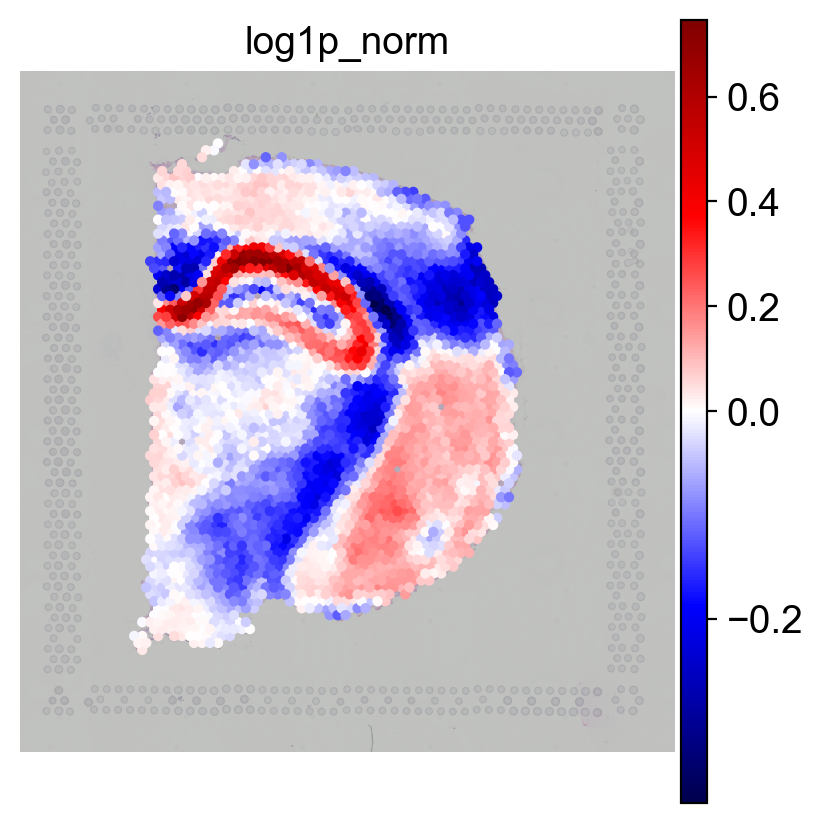

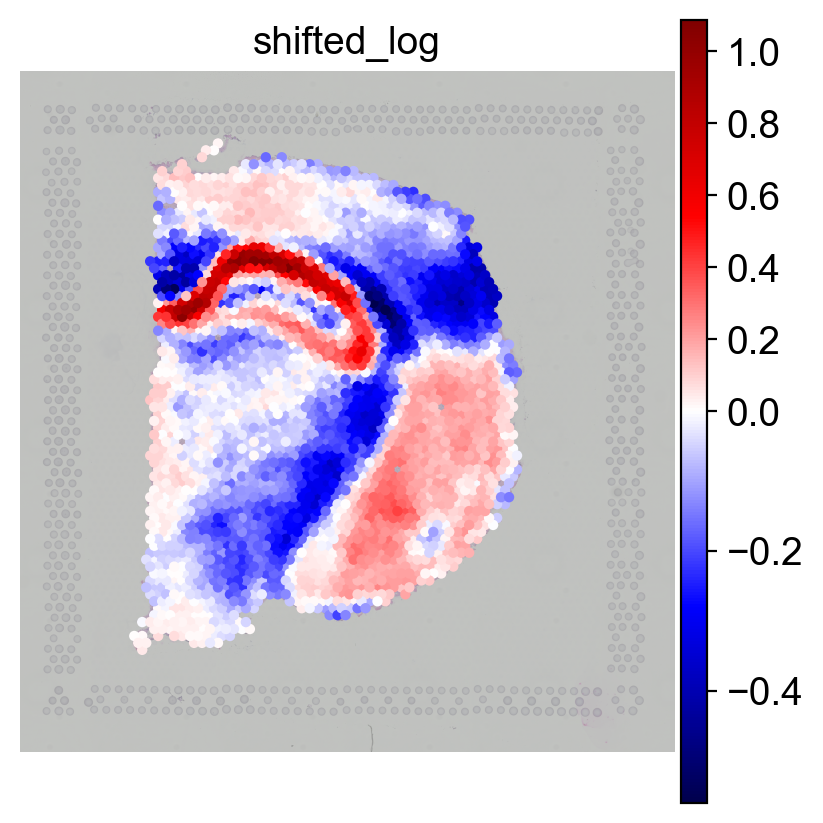

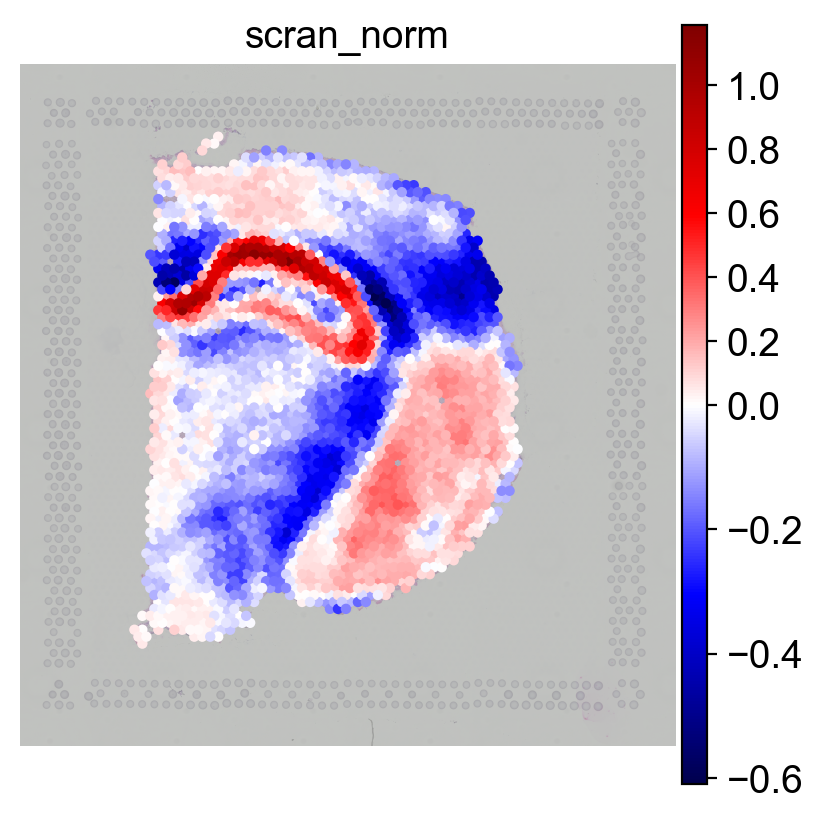

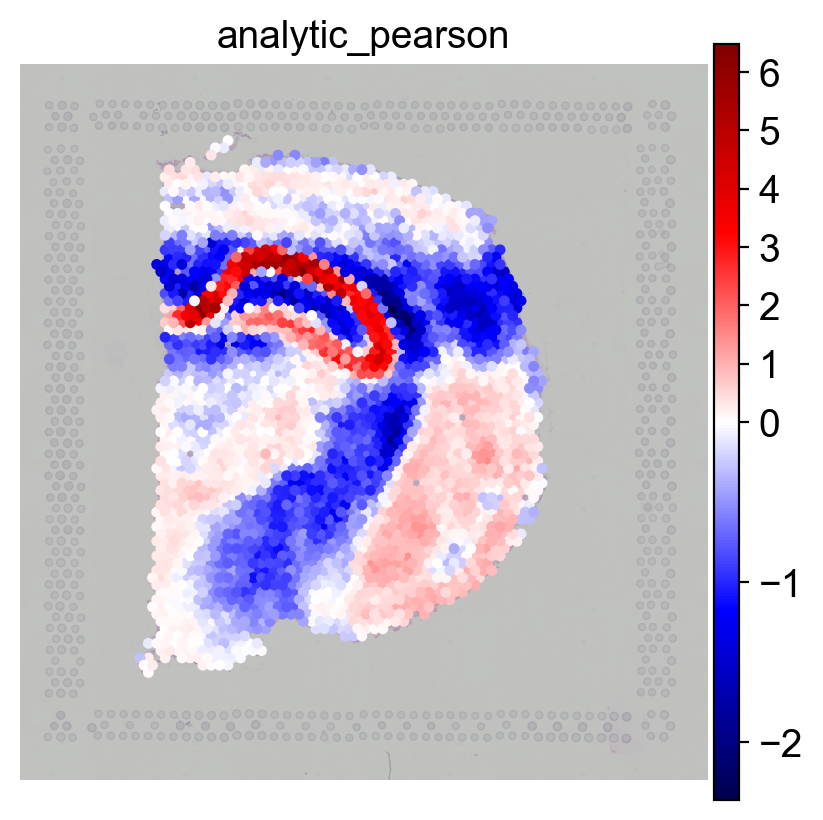

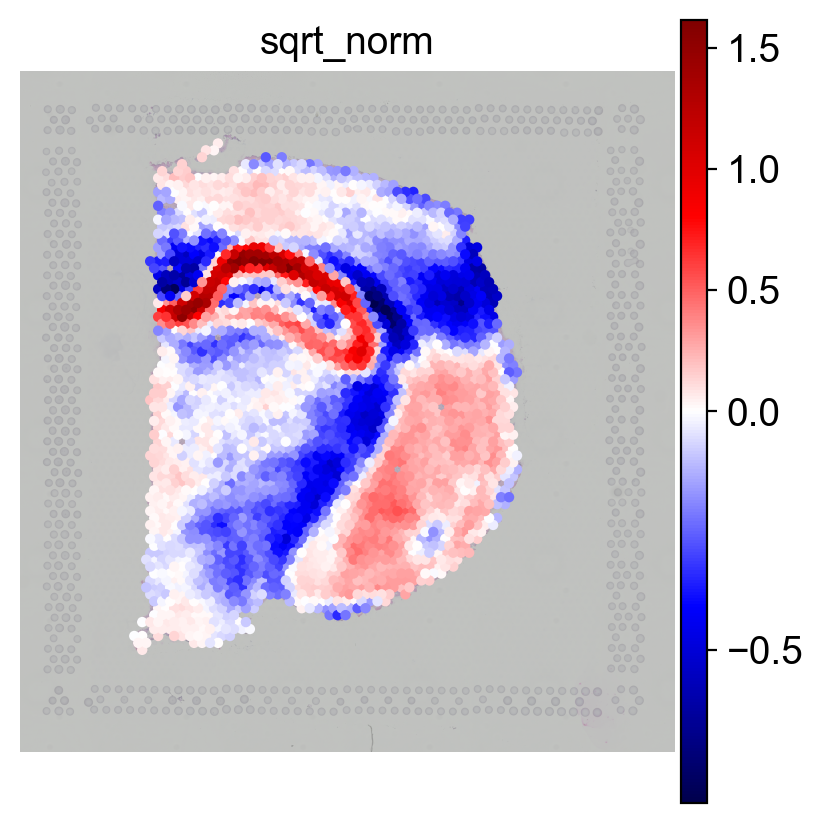

In [19]:
normalisation_methods = ["log1p_norm", "shifted_log", "scran_norm", "analytic_pearson", "sqrt_norm"]

# Prepare list to collect enrichmap scores
enrichmap_scores = []

for normalisation in normalisation_methods:
    adata.X = adata.layers[normalisation].copy()

    # EnrichMap scoring
    adata_temp = adata.copy()
    em.tl.score(
        adata_temp,
        gene_set=gene_set_20,
        smoothing=True,
        correct_spatial_covariates=True,
        batch_key=None
    )

    # Plot spatial enrichment
    sq.pl.spatial_scatter(
        adata_temp,
        color="enrichmap_score",
        img_alpha=0.5,
        size=2,
        ncols=1,
        vcenter=0,
        title=f"{normalisation}",
        save=figure_dir + f"enrichmap_score_{normalisation}.pdf",
    )

    # Collect scores into a dataframe
    scores = adata_temp.obs["enrichmap_score"].copy()
    df_temp = pd.DataFrame({
        "obs_names": scores.index,
        "normalisation": normalisation,
        "score": scores.values
    })
    enrichmap_scores.append(df_temp)

# Concatenate all scores into a single dataframe
scores_df = pd.concat(enrichmap_scores)

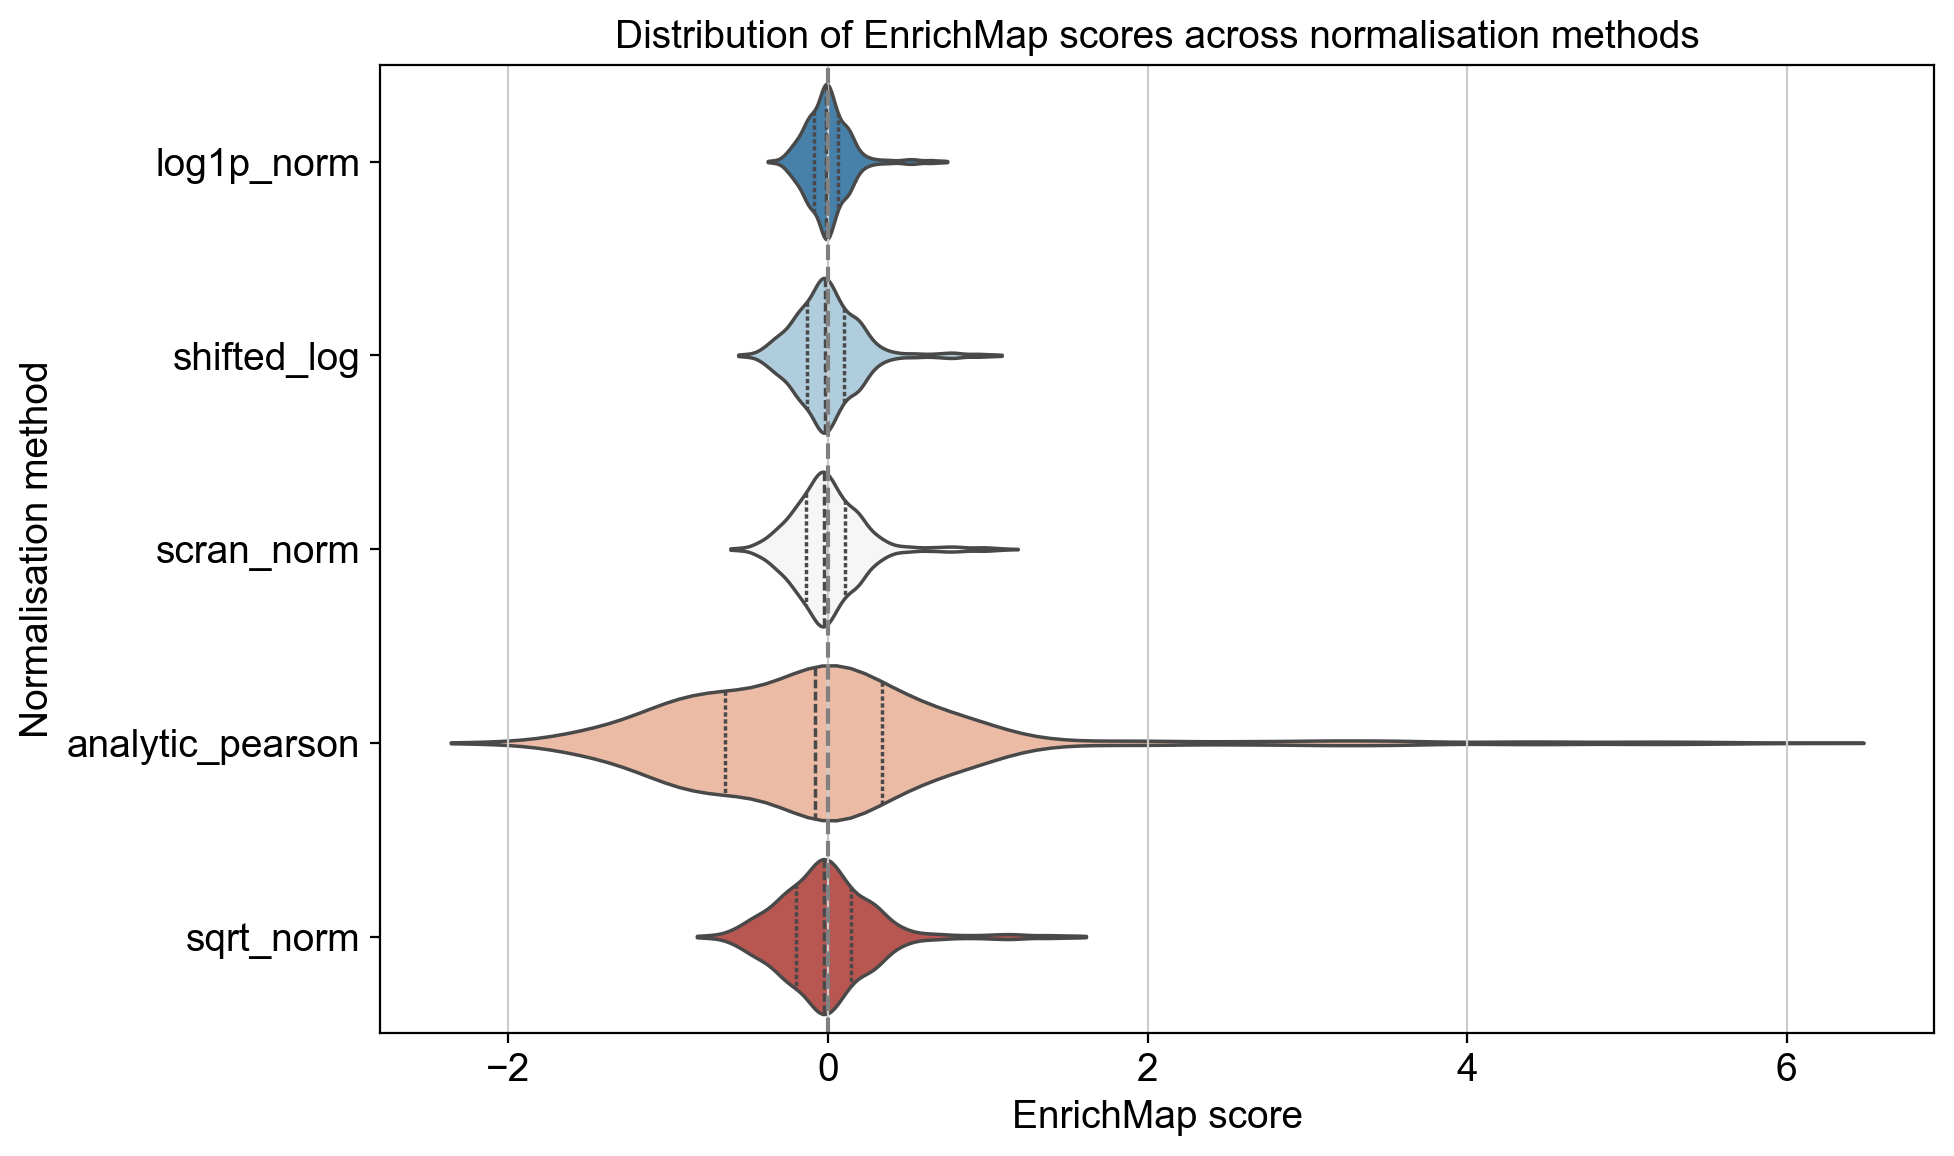

In [20]:
# Ridge plot (overlapping violin plots, sns style)
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=scores_df,
    x="score",
    y="normalisation",
    scale="width",
    inner="quartile",
    bw=0.2,
    cut=0,
    palette="RdBu_r"
)
plt.axvline(0, color="grey", linestyle="--")
plt.title("Distribution of EnrichMap scores across normalisation methods")
plt.xlabel("EnrichMap score")
plt.ylabel("Normalisation method")
plt.tight_layout()
plt.savefig(figure_dir + "enrichmap_scores_normalisation_effect_violin.pdf", dpi=300, bbox_inches="tight")
plt.show()

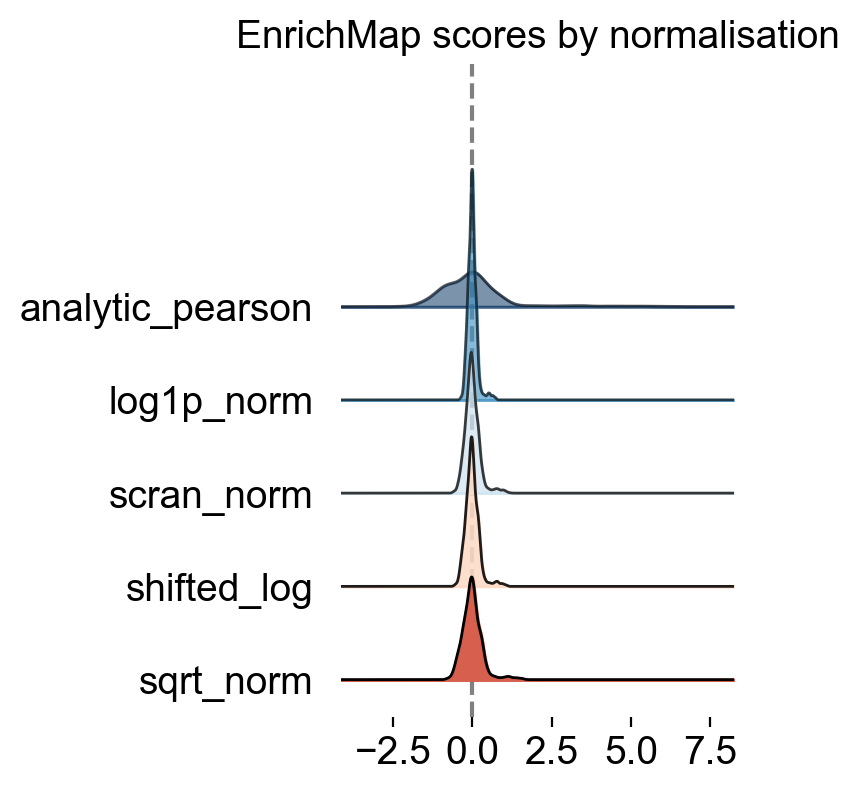

In [21]:
fig, axes = joypy.joyplot(
    scores_df,
    by="normalisation",
    column="score",
    figsize=(4, 4),
    colormap=plt.cm.RdBu_r,
    linewidth=1,
    fade=True
)
plt.title("EnrichMap scores by normalisation")
plt.axvline(0, color="grey", linestyle="--")
plt.savefig(figure_dir + "enrichmap_scores_normalisation_effect_ridge.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Reshape for ICC
df_icc = scores_df.pivot(index="obs_names", columns="normalisation", values="score").reset_index()
icc = pg.intraclass_corr(data=df_icc.melt(id_vars="obs_names"), targets="obs_names", raters="normalisation", ratings="value")

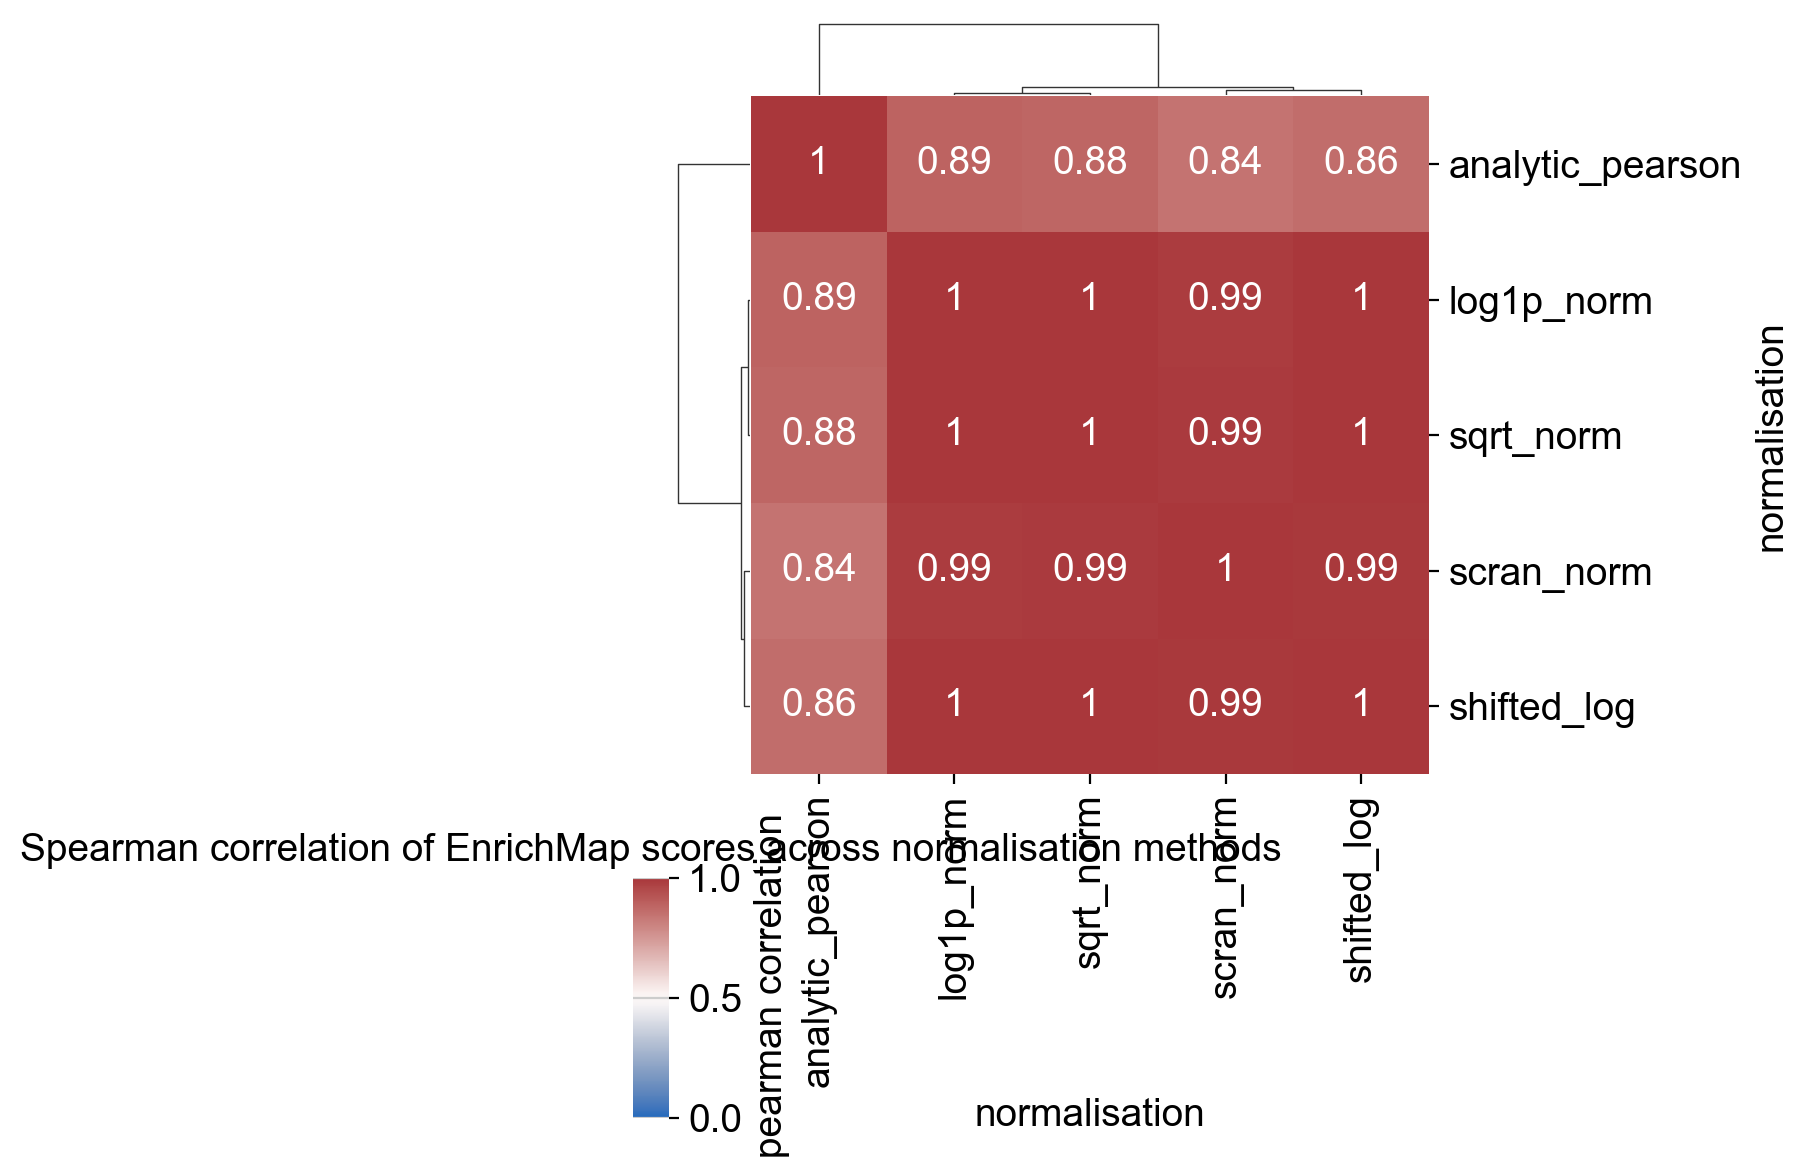

In [23]:
# Pivot so that rows = obs_names, columns = normalisations, values = scores
df_corr = scores_df.pivot(index="obs_names", columns="normalisation", values="score")

# Calculate pairwise Spearman correlations
corr_matrix = df_corr.corr(method="spearman")

g = sns.clustermap(
    corr_matrix,
    annot=True,
    cmap="vlag",
    vmin=0,
    vmax=1,
    figsize=(6, 6),
    cbar_kws={"label": "Spearman correlation"},
    dendrogram_ratio=0.1,
    cbar_pos=(0, 0.05, 0.03, 0.2),
    linewidths=0,
)

g.ax_heatmap.grid(False)
plt.title("Spearman correlation of EnrichMap scores across normalisation methods")
plt.savefig(figure_dir + "enrichmap_scores_spearman.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
normalisation_methods = ["log1p_norm", "shifted_log", "scran_norm", "analytic_pearson", "sqrt_norm"]

# Prepare list to collect enrichmap scores
enrichmap_scores = []

for normalisation in normalisation_methods:
    adata.X = adata.layers[normalisation].copy()

    # EnrichMap scoring
    em.tl.score(
        adata,
        gene_set=gene_set_20,
        score_key=f"enrichmap_{normalisation}",
        smoothing=True,
        correct_spatial_covariates=True,
        batch_key=None
    )

Scoring signatures: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


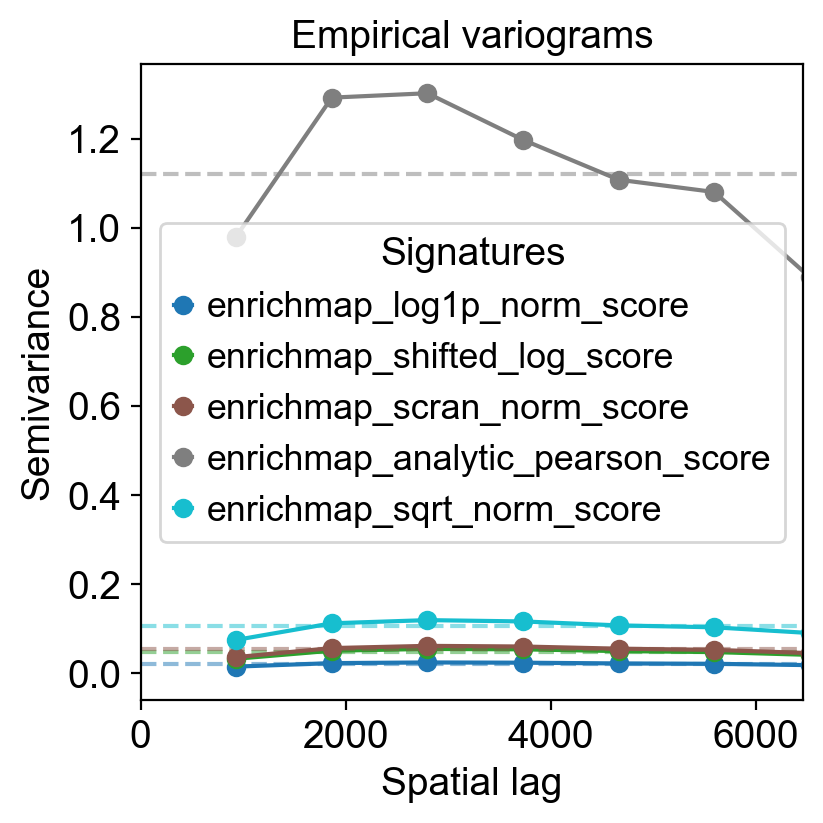

In [25]:
em.pl.variogram_all(
    adata,
    score_keys=[f"enrichmap_{normalisation}_score" for normalisation in normalisation_methods],
    save="enrichmap_scores_variogram.pdf",
)

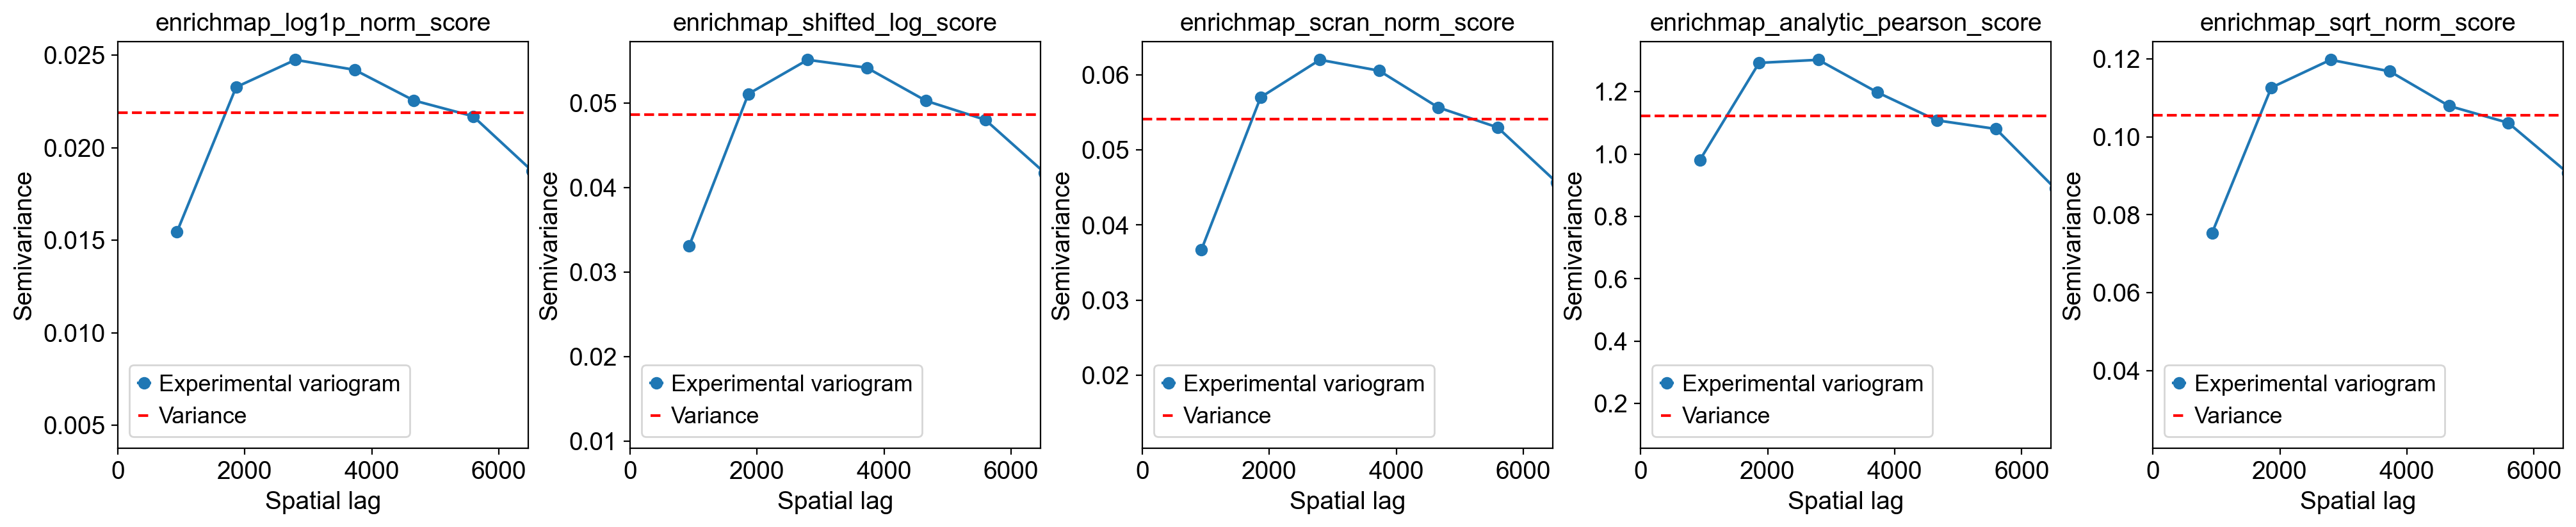

In [26]:
em.pl.variogram(
    adata,
    score_keys=[f"enrichmap_{normalisation}_score" for normalisation in normalisation_methods],
    save="enrichmap_scores_variogram_separate.pdf",
)